# **LIBRARY**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import torch
import math

import logging
import logging.config
import os
import pprint
import yaml
import inspect
import abc

from tqdm import tqdm_notebook as tqdm
from tqdm import trange
from copy import copy
from imblearn.over_sampling import SMOTE

from functools import partial
from attr import attrib, attrs
from attr.validators import instance_of
from collections import namedtuple
from collections import deque
from collections import Counter

from transformers import RobertaTokenizer, RobertaModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, accuracy_score

from keras import backend as K
from keras.models import Sequential
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, Activation, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD

# **DATA UNDERSTANDING**

In [ ]:
df_pariwisata = pd.read_excel('Dataset Pariwisata Preprocessing.xlsx')
df_pariwisata.head(1)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,211,GunungTangkuban perahu,Gunung Tangkuban Parahu adalah salah satu gunu...,Cagar Alam,Bandung,30000,4.5,NaN,"{'lat': -6.759637700000001, 'lng': 107.6097807}",-6.759638,107.609781,NaN,211


In [ ]:
df_rating = pd.read_excel('Dataset Rating Preprocessing.xlsx')
df_rating.head(1)

,username,GunungTangkuban perahu,Jalan Braga,Gedung Sate,Trans Studio Bandung,Taman Hutan Raya Ir. H. Djuanda,Farm House Susu Lembang,Kebun Binatang Bandung,Kawah Putih,Tebing Karaton,...,Glamping Lakeside Rancabali,Bukit Jamur,Happyfarm Ciwidey,Taman Miniatur Kereta Api,Gua Pawon,Bandros City Tour,Kyotoku Floating Market,Rainbow Garden,Kota Mini,Chingu Cafe Little Seoul
0,TripAdvisor,3.5,4.0,4.0,4.0,4.0,0.0,2.5,4.0,4.0,...,4.0,4.0,0.0,0.0,4.0,0.0,0.0,4.5,0.0,3.0


In [ ]:
print(df_rating['username'].to_list())

['TripAdvisor', 'Google Maps', 'klook', 'holidify', 'agoda', 'traveloka', 'tiket', 'booking', 'BaseBDG', 'KompasTV', 'liputan6dotcom', 'kompasiana', 'detikTravel', 'kumparan', 'ayobandungcom', 'detikcom', 'pikiran_rakyat', 'mapaybandungcom', 'PRFMnews', 'kompascom', 'halo_bandung', 'tempodotco', 'merdekadotcom', 'inewsdotid', 'kabarlhk', 'infobdg', 'mediaindonesia', 'TuitJabar', 'RadioElshinta', 'rakafm_bandung', 'KompasTravel', 'SummareconBdg', 'AATaksi_Bandung', 'VIVA_log', 'sannyabraham', 'JavaWisata_', 'Your_Bandung', 'pegipegi', 'infobandung123', 'dian_job', 'ClickBandung', 'idbcpr', 'disparbud_jabar', 'VIVAcoid', 'goodnewsbdg', 'divusiinstitute', 'sekitarbandung_', 'Eventorganizer_', 'Bandung_Update', 'CNNIDdaily', 'humasbandung_', 'keluyuranaja', 'lnfobandung', 'jacktourbandung', 'destinasibdg', 'seputarbdgraya', 'travelogers', 'Faveticket', 'AviaWisata', 'tribunnews', 'kiranagianni', 'krisxoxom', 'RatnoWistu', 'gghwngy', 'ProkopimKabBdg', 'yctravella', 'bestprofitbdg', 'iniband

# **MODEL ROBERTA DAN TF-IDF**

In [ ]:
# Tokenizer RoBERTa
model = RobertaModel.from_pretrained('roberta-base')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

token = df_pariwisata['Description'].apply(tokenizer.encode)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (3273 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
# Menghitung Frekuensi Token (TF)
def calc_token(token):
    count_token = {}
    for document in token:
        for term in document:
            if term in count_token:count_token[term] += 1
            else:count_token[term] = 1
    return count_token

In [ ]:
freq_token = calc_token(token)

In [ ]:
# Menghitung TF (Term Frequency)
tf_all = {}
for n in freq_token.keys():
    tf_all[n] = freq_token[n]/max(max(token))

print(tf_all)

{0: 0.001975338201843649, 39916: 9.976455564866914e-05, 1545: 0.007941258629634063, 20749: 0.00015962328903787064, 330: 0.0026138313579951314, 1792: 0.0002793407558162736, 260: 0.010415419609721059, 2884: 0.00023943493355680593, 17421: 0.00011971746677840296, 2329: 0.0020551498463625842, 337: 0.003691288559000758, 895: 0.00979687936469931, 6641: 0.0007981164451893531, 4005: 0.001057504289875893, 257: 0.006065684983439084, 1751: 0.00037910531146494273, 1423: 0.007901352807374596, 1097: 0.012530428189472843, 8470: 0.0038908176702980965, 2716: 0.0007183048006704178, 677: 0.007382577118001516, 2269: 0.006384931561514825, 13786: 0.00011971746677840296, 1344: 0.0001396703779081368, 118: 0.00776168242946646, 344: 0.0018755736461949799, 6498: 0.0008978810008380223, 1731: 0.0012969392234326988, 415: 0.006245261183606688, 6: 0.011073865677002274, 5722: 0.0005586815116325472, 4: 0.01225108743365657, 21780: 7.981164451893532e-05, 14369: 0.0006384931561514825, 291: 7.981164451893532e-05, 6301: 0.00

In [ ]:
# Menghitung IDF (Inverse Document Frequency)
idf_all = {}
for n in tf_all.keys():
    idf_all[n] = 1 + np.log10(max(max(token))/ freq_token[n])

print(idf_all)

{0: 3.704358537191952, 39916: 5.001023727453483, 1545: 3.100110659715814, 20749: 4.796903744797558, 330: 3.5827224361337375, 1792: 4.553865696111263, 260: 2.9823232287872394, 2884: 4.620812485741877, 17421: 4.921842481405858, 2329: 3.6871565070843295, 337: 3.432822003386488, 895: 3.0089122396665333, 6641: 4.097933740461539, 4005: 3.9757178621887124, 257: 3.2171201481807477, 1751: 4.421240130836672, 1423: 3.1022985458639893, 1097: 2.9020340880523054, 8470: 3.4099591204269837, 2716: 4.143691231022214, 677: 3.1317920077225065, 2269: 3.1948437534695957, 13786: 4.921842481405858, 1344: 4.854895691775244, 118: 3.110044130463794, 344: 3.7268658781898027, 6498: 4.046781218014158, 1731: 3.887080375146646, 415: 3.204449394243053, 6: 2.9557007486668256, 5722: 4.2528357004472825, 4: 2.9118253606483337, 21780: 5.0979337404615395, 14369: 4.194843753469596, 291: 5.0979337404615395, 6301: 4.796903744797558, 7321: 3.5477053874064453, 10: 4.037235900107928, 9772: 5.222872477069839, 16080: 4.357571050967

In [ ]:
tfidf_all = {}
for n in freq_token.keys():
    tfidf_all[n] = tf_all[n] * idf_all[n]

print(tfidf_all)

{0: 0.007317360931840921, 39916: 0.0004989249099578478, 1545: 0.024618780529288755, 20749: 0.0007656975529426647, 330: 0.009364632250559073, 1792: 0.0012720802854375211, 260: 0.031062147839637236, 2884: 0.0011063839305020654, 17421: 0.0005892305137562382, 2329: 0.0075776591290491625, 337: 0.012671536586186603, 895: 0.029477950230980245, 6641: 0.0032706283095586723, 4005: 0.004204338694600777, 257: 0.019514037372739282, 1751: 0.0016761156168621407, 1423: 0.02451235532467656, 1097: 0.036363729743741725, 8470: 0.013267529200751462, 2716: 0.00297643330373917, 677: 0.023120696014552203, 2269: 0.02039885871563651, 13786: 0.0005892305137562382, 1344: 0.0006780851159748336, 118: 0.024139174882286122, 344: 0.006990011424036104, 6498: 0.003633527970203063, 1731: 0.005041307003163175, 415: 0.020012623416698107, 6: 0.032731033072151486, 5722: 0.0023759806778507505, 4: 0.03567302708484131, 21780: 0.00040687447547480265, 14369: 0.002678379027715134, 291: 0.00040687447547480265, 6301: 0.0007656975529

In [ ]:
# Menyusun DataFrame dengan TF-IDF
df_ready = pd.DataFrame(np.zeros((len(token), max(max(token))+1)))

for i in tqdm(range(len(token))):
    pre_text = token[i]
    for word in pre_text:
        df_ready[word][i] = tfidf_all[word]

# Menggabungkan Data TF-IDF dengan Data Rating
df_pariwisata['roberta_tfidf'] = list(df_ready.to_numpy())

<ipython-input-11-31d17c1d2f7d>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(token))):


  0%|          | 0/99 [00:00<?, ?it/s]

In [ ]:
data_embd = np.vstack(df_pariwisata['roberta_tfidf'].to_numpy())

In [ ]:
profile_user_tfidf = df_rating.columns[1:]
X_tfidf = np.hstack([df_rating[profile_user_tfidf].to_numpy().T, data_embd])
y_tfidf = df_rating.iloc[:, 1:].to_numpy().T

In [ ]:
# Pelatihan Model dan Evaluasi
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y_tfidf, test_size=0.2, random_state=42)

In [ ]:
model_tfidf = LinearRegression()
model_tfidf.fit(X_train_tfidf, y_train_tfidf)

y_pred_tfidf = model_tfidf.predict(X_test_tfidf)

In [ ]:
mae_cbf_embedding_tfidf = mean_absolute_error(y_test_tfidf, y_pred_tfidf)
mse_value_tfidf = mean_squared_error(y_test_tfidf, y_pred_tfidf)
rmse_cbf_embedding_tfidf = np.sqrt(mse_value_tfidf)

print(f'Mean Absolute Error: {mae_cbf_embedding_tfidf}')
print(f'Root Mean Squared Error: {(rmse_cbf_embedding_tfidf)}')

Mean Absolute Error: 0.4204348533043587
Root Mean Squared Error: 0.5726578056054936


In [ ]:
# Normalisasi
rating_pred_tfidf = model_tfidf.predict(X_tfidf)

scaler_tfidf = MinMaxScaler(feature_range=(1, 5))
normalized_ratings_tfidf = scaler_tfidf.fit_transform(rating_pred_tfidf.reshape(-1, 1))

In [ ]:
rekomendasi_tfidf = df_rating.copy()

rekomendasi_tfidf.iloc[:, 1:] = normalized_ratings_tfidf[:len(rekomendasi_tfidf) * 99].reshape(len(rekomendasi_tfidf), 99)
rekomendasi_tfidf

,username,GunungTangkuban perahu,Jalan Braga,Gedung Sate,Trans Studio Bandung,Taman Hutan Raya Ir. H. Djuanda,Farm House Susu Lembang,Kebun Binatang Bandung,Kawah Putih,Tebing Karaton,...,Glamping Lakeside Rancabali,Bukit Jamur,Happyfarm Ciwidey,Taman Miniatur Kereta Api,Gua Pawon,Bandros City Tour,Kyotoku Floating Market,Rainbow Garden,Kota Mini,Chingu Cafe Little Seoul
0,TripAdvisor,3.593208,4.382321,3.593932,3.560836,2.227456,2.068098,3.952393,1.669340,3.333853,...,1.928814,2.101315,2.074130,1.879749,1.581964,1.739181,3.878021,4.267861,1.928820,4.121671
1,Google Maps,1.928820,1.928820,1.928820,1.928820,2.903420,1.928820,3.390721,3.878021,3.390721,...,1.928820,1.928820,3.878021,4.219131,1.928820,3.780561,1.928820,1.928820,1.928820,1.928820
2,klook,1.928820,3.390721,1.928820,3.878021,4.365321,1.928820,1.928820,1.928820,3.878021,...,3.926751,1.928820,1.928820,4.121671,3.975481,1.928820,1.928820,1.928820,1.928820,1.928820
3,holidify,3.390721,3.878021,1.928820,1.928820,1.928820,1.928820,1.928820,3.878021,1.928820,...,2.009428,2.060924,4.048724,2.356654,3.878306,3.907415,2.967474,3.580888,1.479035,3.446127
4,agoda,3.835101,2.772581,3.537891,2.898484,1.755244,2.989828,1.778169,1.468833,3.057727,...,1.928820,1.928820,3.390721,1.928820,1.928820,1.928820,3.878021,3.878021,3.390721,3.390721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,aboutbdgcom,1.928820,1.928820,1.928820,1.928820,1.928820,1.928820,1.928820,1.928820,1.928820,...,1.928820,1.928820,3.390721,3.390721,1.928820,1.928820,1.928820,3.390721,3.390721,3.390721
91,Suka_Bandung,3.390721,1.928820,3.390721,3.390721,1.928820,1.928820,1.928820,1.928820,1.928820,...,2.182606,1.658243,2.956278,1.881515,2.360241,1.979048,2.084920,3.655925,2.286295,1.627797
92,NET_CJ,2.301093,1.797941,1.950806,1.915865,1.911304,1.652955,1.461023,1.791048,1.828632,...,1.928820,1.928820,1.928820,3.390721,1.928820,1.928820,1.928820,1.928820,1.928820,1.928820
93,bandung911,1.928820,1.928820,1.928820,1.928820,3.878021,1.928820,1.928820,1.928820,2.044007,...,2.040807,1.917091,2.069941,1.984253,2.366455,1.764914,1.813336,1.664983,2.168649,3.590825


In [ ]:
# Konversi Rating ke Format Biner
arr_tfidf = rekomendasi_tfidf.to_numpy()

for i in range(len(arr_tfidf)):
    for j in range(1,len(arr_tfidf[i])):
        rate = arr_tfidf[i][j]
        if rate > 3:arr_tfidf[i][j]=1
        else:arr_tfidf[i][j]=0

df_tfidf_binary = pd.DataFrame(arr_tfidf,columns=rekomendasi_tfidf.columns)
df_tfidf_binary = df_tfidf_binary.drop('username', axis=1)
df_tfidf_binary = df_tfidf_binary.astype('int')
df_tfidf_binary

,GunungTangkuban perahu,Jalan Braga,Gedung Sate,Trans Studio Bandung,Taman Hutan Raya Ir. H. Djuanda,Farm House Susu Lembang,Kebun Binatang Bandung,Kawah Putih,Tebing Karaton,Dusun Bambu,...,Glamping Lakeside Rancabali,Bukit Jamur,Happyfarm Ciwidey,Taman Miniatur Kereta Api,Gua Pawon,Bandros City Tour,Kyotoku Floating Market,Rainbow Garden,Kota Mini,Chingu Cafe Little Seoul
0,1,1,1,1,0,0,1,0,1,0,...,0,0,0,0,0,0,1,1,0,1
1,0,0,0,0,0,0,1,1,1,1,...,0,0,1,1,0,1,0,0,0,0
2,0,1,0,1,1,0,0,0,1,0,...,1,0,0,1,1,0,0,0,0,0
3,1,1,0,0,0,0,0,1,0,1,...,0,0,1,0,1,1,0,1,0,1
4,1,0,1,0,0,0,0,0,1,1,...,0,0,1,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,1,1,1
91,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
92,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
93,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


# **RNN**

In [ ]:
for i in range(len(df_tfidf_binary.columns)):
    X = df_tfidf_binary.drop([df_tfidf_binary.columns[i]],axis = 1).values
    y = df_tfidf_binary.iloc[:, i].values

print(X.shape)
print(y.shape)

(95, 98)
(95,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=40, test_size = 0.5, stratify=y)

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
def rnn_model():
    model = Sequential()
    model.add(Embedding(1, 100, input_length=98))
    model.add(SimpleRNN(64, return_sequences = True))
    model.add(Dropout(0.5))
    model.add(SimpleRNN(64, return_sequences = True))
    model.add(Dropout(0.5))
    model.add(SimpleRNN(64))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Dense(2))
    model.add(Activation('sigmoid'))
    model.build()
    return model

## Roberta-TFIDF-Adam

In [ ]:
# Membuat Model RNN dan Menggunakan Optimizer Adam
model = rnn_model()
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
# Melatih Model
history = model.fit(X_train, y_train, epochs=10, validation_data =(X_test, y_test))
history

Epoch 1/10
2/2 [==============================] - 8s 775ms/step - loss: 0.7425 - accuracy: 0.6383 - val_loss: 0.5083 - val_accuracy: 0.7917
Epoch 2/10
2/2 [==============================] - 1s 327ms/step - loss: 0.6761 - accuracy: 0.7660 - val_loss: 0.5398 - val_accuracy: 0.7917
Epoch 3/10
2/2 [==============================] - 1s 301ms/step - loss: 0.6712 - accuracy: 0.7660 - val_loss: 0.5530 - val_accuracy: 0.7917
Epoch 4/10
2/2 [==============================] - 1s 320ms/step - loss: 0.6295 - accuracy: 0.8085 - val_loss: 0.5657 - val_accuracy: 0.7917
Epoch 5/10
2/2 [==============================] - 1s 307ms/step - loss: 0.6596 - accuracy: 0.8085 - val_loss: 0.5814 - val_accuracy: 0.7917
Epoch 6/10
2/2 [==============================] - 1s 308ms/step - loss: 0.5909 - accuracy: 0.8085 - val_loss: 0.5855 - val_accuracy: 0.7917
Epoch 7/10
2/2 [==============================] - 1s 314ms/step - loss: 0.6358 - accuracy: 0.8085 - val_loss: 0.5760 - val_accuracy: 0.7917
Epoch 8/10
2/2 [====

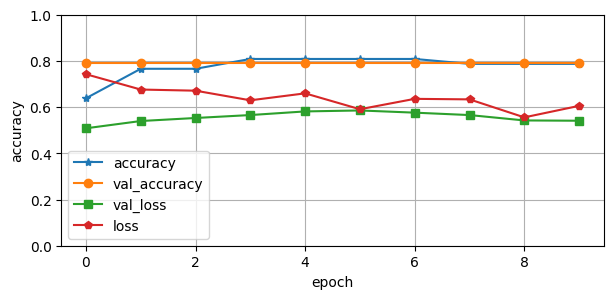

In [ ]:
# Visualisasi Hasil Pelatihan
df_his_rnn = pd.DataFrame(history.history)
plt.figure(figsize=(7, 3))
plt.plot(history.history['accuracy'],marker='*')
plt.plot(history.history['val_accuracy'],marker='o')
plt.plot(history.history['val_loss'],marker='s')
plt.plot(history.history['loss'],marker='p')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.legend(['accuracy','val_accuracy','val_loss','loss'])
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

print('Akurasi:',accuracy_score(y_test,y_pred))

2/2 [==============================] - 0s 25ms/step
Akurasi: 0.7916666666666666


In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        38
           1       0.00      0.00      0.00        10

   micro avg       0.79      0.79      0.79        48
   macro avg       0.40      0.50      0.44        48
weighted avg       0.63      0.79      0.70        48
 samples avg       0.79      0.79      0.79        48



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Roberta-TFIDF-SGD

In [ ]:
# Membuat Model RNN dan Menggunakan Optimizer SGD
model = rnn_model()
opt = SGD(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
# Melatih Model
history = model.fit(X_train, y_train, epochs=10, validation_data =(X_test, y_test))
history

Epoch 1/10
2/2 [==============================] - 4s 763ms/step - loss: 0.8069 - accuracy: 0.5106 - val_loss: 0.7193 - val_accuracy: 0.4583
Epoch 2/10
2/2 [==============================] - 1s 294ms/step - loss: 0.7229 - accuracy: 0.5106 - val_loss: 0.7204 - val_accuracy: 0.4792
Epoch 3/10
2/2 [==============================] - 1s 323ms/step - loss: 0.7971 - accuracy: 0.5106 - val_loss: 0.7117 - val_accuracy: 0.5000
Epoch 4/10
2/2 [==============================] - 1s 294ms/step - loss: 0.8736 - accuracy: 0.4468 - val_loss: 0.7242 - val_accuracy: 0.5208
Epoch 5/10
2/2 [==============================] - 1s 330ms/step - loss: 0.8917 - accuracy: 0.4681 - val_loss: 0.6896 - val_accuracy: 0.6042
Epoch 6/10
2/2 [==============================] - 1s 286ms/step - loss: 0.7248 - accuracy: 0.6383 - val_loss: 0.6757 - val_accuracy: 0.5833
Epoch 7/10
2/2 [==============================] - 1s 322ms/step - loss: 0.7763 - accuracy: 0.5745 - val_loss: 0.6629 - val_accuracy: 0.7083
Epoch 8/10
2/2 [====

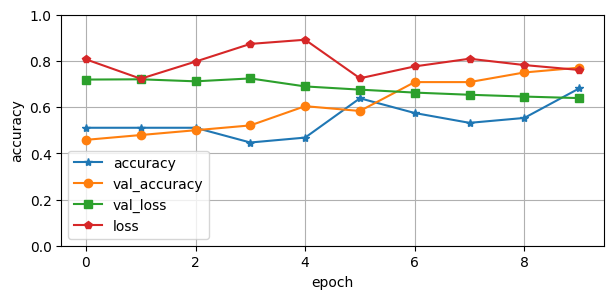

In [ ]:
df_his_rnn = pd.DataFrame(history.history)
plt.figure(figsize=(7, 3))
plt.plot(history.history['accuracy'],marker='*')
plt.plot(history.history['val_accuracy'],marker='o')
plt.plot(history.history['val_loss'],marker='s')
plt.plot(history.history['loss'],marker='p')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.legend(['accuracy','val_accuracy','val_loss','loss'])
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

print('Akurasi:',accuracy_score(y_test,y_pred))

2/2 [==============================] - 0s 25ms/step
Akurasi: 0.4166666666666667


In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.61      0.69        38
           1       0.00      0.00      0.00        10

   micro avg       0.72      0.48      0.57        48
   macro avg       0.40      0.30      0.34        48
weighted avg       0.63      0.48      0.54        48
 samples avg       0.45      0.48      0.46        48



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# SMOTE

In [ ]:
oversample = SMOTE() #Oversampling dengan SMOTE
x_smote, y_smote = oversample.fit_resample(X, y)

In [ ]:
# Membagi Data Menjadi Data Pelatihan dan Pengujian
X_train, X_test, y_train, y_test = train_test_split(x_smote,y_smote, random_state=40, test_size = 0.5, stratify=y_smote)

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Roberta-TFIDF-Adam-Smote

In [ ]:
model = rnn_model()
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data =(X_test, y_test))
history

Epoch 1/10
3/3 [==============================] - 5s 557ms/step - loss: 0.7355 - accuracy: 0.4605 - val_loss: 0.7101 - val_accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - 2s 585ms/step - loss: 0.7177 - accuracy: 0.6053 - val_loss: 0.7056 - val_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 1s 436ms/step - loss: 0.7621 - accuracy: 0.4211 - val_loss: 0.7036 - val_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 1s 284ms/step - loss: 0.7645 - accuracy: 0.4079 - val_loss: 0.7004 - val_accuracy: 0.5000
Epoch 5/10
3/3 [==============================] - 1s 273ms/step - loss: 0.7686 - accuracy: 0.4211 - val_loss: 0.6979 - val_accuracy: 0.5000
Epoch 6/10
3/3 [==============================] - 1s 270ms/step - loss: 0.7621 - accuracy: 0.4605 - val_loss: 0.6931 - val_accuracy: 0.4868
Epoch 7/10
3/3 [==============================] - 1s 273ms/step - loss: 0.7551 - accuracy: 0.5789 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 8/10
3/3 [====

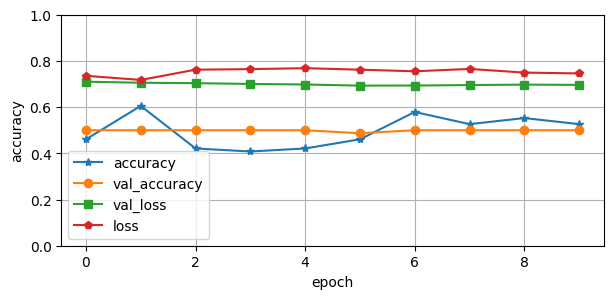

In [ ]:
df_his_rnn = pd.DataFrame(history.history)
df_his_rnn = pd.DataFrame(history.history)
plt.figure(figsize=(7, 3))
plt.plot(history.history['accuracy'],marker='*')
plt.plot(history.history['val_accuracy'],marker='o')
plt.plot(history.history['val_loss'],marker='s')
plt.plot(history.history['loss'],marker='p')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.legend(['accuracy','val_accuracy','val_loss','loss'])
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

print('Akurasi:',accuracy_score(y_test,y_pred))

3/3 [==============================] - 0s 26ms/step
Akurasi: 0.5


In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        38
           1       0.00      0.00      0.00        38

   micro avg       0.50      0.50      0.50        76
   macro avg       0.25      0.50      0.33        76
weighted avg       0.25      0.50      0.33        76
 samples avg       0.50      0.50      0.50        76



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Roberta-TFIDF-SGD-SMOTE

In [ ]:
model = rnn_model()
opt = SGD(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data =(X_test, y_test))
history

Epoch 1/10
3/3 [==============================] - 5s 519ms/step - loss: 0.7316 - accuracy: 0.4737 - val_loss: 0.7061 - val_accuracy: 0.3553
Epoch 2/10
3/3 [==============================] - 1s 279ms/step - loss: 0.7215 - accuracy: 0.5263 - val_loss: 0.7033 - val_accuracy: 0.5526
Epoch 3/10
3/3 [==============================] - 1s 269ms/step - loss: 0.7628 - accuracy: 0.3553 - val_loss: 0.7032 - val_accuracy: 0.5263
Epoch 4/10
3/3 [==============================] - 1s 270ms/step - loss: 0.7430 - accuracy: 0.5000 - val_loss: 0.7023 - val_accuracy: 0.5658
Epoch 5/10
3/3 [==============================] - 1s 283ms/step - loss: 0.7263 - accuracy: 0.5000 - val_loss: 0.7021 - val_accuracy: 0.5658
Epoch 6/10
3/3 [==============================] - 1s 282ms/step - loss: 0.7286 - accuracy: 0.5132 - val_loss: 0.7010 - val_accuracy: 0.6184
Epoch 7/10
3/3 [==============================] - 1s 269ms/step - loss: 0.7183 - accuracy: 0.4868 - val_loss: 0.7011 - val_accuracy: 0.5658
Epoch 8/10
3/3 [====

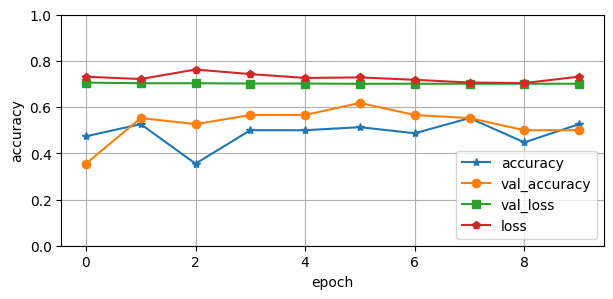

In [ ]:
df_his_rnn = pd.DataFrame(history.history)
df_his_rnn = pd.DataFrame(history.history)
df_his_rnn = pd.DataFrame(history.history)
plt.figure(figsize=(7, 3))
plt.plot(history.history['accuracy'],marker='*')
plt.plot(history.history['val_accuracy'],marker='o')
plt.plot(history.history['val_loss'],marker='s')
plt.plot(history.history['loss'],marker='p')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.legend(['accuracy','val_accuracy','val_loss','loss'])
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

print('Akurasi:',accuracy_score(y_test,y_pred))

3/3 [==============================] - 0s 23ms/step
Akurasi: 0.5


In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.11      0.19        38
           1       0.54      1.00      0.70        38

   micro avg       0.56      0.55      0.56        76
   macro avg       0.77      0.55      0.44        76
weighted avg       0.77      0.55      0.44        76
 samples avg       0.53      0.55      0.54        76



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Roberta-TfIdf-PSO

In [ ]:
# Mengolah Data
for i in range(len(df_tfidf_binary.columns)):
    X = df_tfidf_binary.drop([df_tfidf_binary.columns[i]],axis = 1).values
    y = df_tfidf_binary.iloc[:, i].values

print(X.shape)
print(y.shape)

(95, 98)
(95,)


In [ ]:
# Menghitung Logits
def logits_function(p):
    W1 = p[0:9310].reshape((98,95))
    b1 = p[9310:9405].reshape((95,))
    W2 = p[9405:9595].reshape((95,2))
    b2 = p[9595:9597].reshape((2,))

    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    logits = a1.dot(W2) + b2
    return logits

In [ ]:
def forward_prop(params):
    logits = logits_function(params)

    exp_scores = np.exp(logits)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    corect_logprobs = -np.log(probs[range(95), y])
    loss = np.sum(corect_logprobs) / 95
    return loss

In [ ]:
def f(x):
    n_particles = x.shape[0]
    j = [forward_prop(x[i]) for i in range(n_particles)]
    return np.array(j)

In [ ]:
class Reporter(object):
    def __init__(
        self, log_path=None, config_path=None, logger=None, printer=None
    ):
        self.logger = logger or logging.getLogger(__name__)
        self.printer = printer or pprint.PrettyPrinter()
        self.log_path = log_path or (os.getcwd() + "/report.log")
        self._bar_fmt = "{l_bar}{bar}|{n_fmt}/{total_fmt}{postfix}"
        self._env_key = "LOG_CFG"
        self._default_config = {
            "version": 1,
            "disable_existing_loggers": False,
            "formatters": {
                "standard": {
                    "format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
                }
            },
            "handlers": {
                "default": {
                    "level": "INFO",
                    "class": "logging.StreamHandler",
                    "formatter": "standard",
                },
                "file_default": {
                    "level": "INFO",
                    "formatter": "standard",
                    "class": "logging.handlers.RotatingFileHandler",
                    "filename": self.log_path,
                    "encoding": "utf8",
                    "maxBytes": 10485760,
                    "backupCount": 20,
                },
            },
            "loggers": {
                "": {
                    "handlers": ["default", "file_default"],
                    "level": "INFO",
                    "propagate": True,
                }
            },
        }
        self._setup_logger(config_path)

    def log(self, msg, lvl=logging.INFO, *args, **kwargs):
        self.logger.log(lvl, msg, *args, **kwargs)

    def print(self, msg, verbosity, threshold=0):
        if verbosity > threshold:
            self.printer.pprint(msg)
        else:
            pass

    def _setup_logger(self, path=None):
        value = path or os.getenv(self._env_key, None)
        try:
            with open(value, "rt") as f:
                config = yaml.safe_load(f.read())
            logging.config.dictConfig(config)
        except (TypeError, FileNotFoundError):
            self._load_defaults()

    def _load_defaults(self):
        logging.config.dictConfig(self._default_config)

    def pbar(self, iters, desc=None):
        self.t = trange(iters, desc=desc, bar_format=self._bar_fmt)
        return self.t

    def hook(self, *args, **kwargs):
        self.t.set_postfix(*args, **kwargs)

In [ ]:
class HandlerMixin(object):
    def _merge_dicts(self, *dict_args):
        result = {}
        for dictionary in dict_args:
            result.update(dictionary)
        return result

    def _out_of_bounds(self, position, bounds):
        lb, ub = bounds
        greater_than_bound = np.nonzero(position > ub)
        lower_than_bound = np.nonzero(position < lb)
        return (lower_than_bound, greater_than_bound)

    def _get_all_strategies(self):
        return {
            k: v
            for k, v in inspect.getmembers(self, predicate=inspect.isroutine)
            if not k.startswith(("__", "_"))
        }

In [ ]:
class BoundaryHandler(HandlerMixin):
    def __init__(self, strategy):
        self.strategy = strategy
        self.strategies = self._get_all_strategies()
        self.rep = Reporter(logger=logging.getLogger(__name__))
        self.memory = None

    def __call__(self, position, bounds, **kwargs):
        try:
            new_position = self.strategies[self.strategy](
                position, bounds, **kwargs
            )
        except KeyError:
            message = "Unrecognized strategy: {}. Choose one among: " + str(
                [strat for strat in self.strategies.keys()]
            )
            self.rep.logger.exception(message.format(self.strategy))
            raise
        else:
            return new_position

    def nearest(self, position, bounds, **kwargs):
        lb, ub = bounds
        bool_greater = position > ub
        bool_lower = position < lb
        new_pos = np.where(bool_lower, lb, position)
        new_pos = np.where(bool_greater, ub, new_pos)
        return new_pos

    def reflective(self, position, bounds, **kwargs):
        lb, ub = bounds
        lower_than_bound, greater_than_bound = self._out_of_bounds(
            position, bounds
        )
        new_pos = position
        while lower_than_bound[0].size != 0 or greater_than_bound[0].size != 0:
            if lower_than_bound[0].size > 0:
                new_pos[lower_than_bound] = (
                    2 * lb[lower_than_bound[1]] - new_pos[lower_than_bound]
                )
            if greater_than_bound[0].size > 0:
                new_pos[greater_than_bound] = (
                    2 * ub[greater_than_bound[1]] - new_pos[greater_than_bound]
                )
            lower_than_bound, greater_than_bound = self._out_of_bounds(
                new_pos, bounds
            )

        return new_pos

    def shrink(self, position, bounds, **kwargs):
        if self.memory is None:
            new_pos = position
            self.memory = new_pos
        else:
            lb, ub = bounds
            lower_than_bound, greater_than_bound = self._out_of_bounds(
                position, bounds
            )
            velocity = position - self.memory
            sigma = np.tile(1.0, position.shape)
            sigma[lower_than_bound] = (
                lb[lower_than_bound[1]] - self.memory[lower_than_bound]
            ) / velocity[lower_than_bound]
            sigma[greater_than_bound] = (
                ub[greater_than_bound[1]] - self.memory[greater_than_bound]
            ) / velocity[greater_than_bound]
            min_sigma = np.amin(sigma, axis=1)
            new_pos = position
            new_pos[lower_than_bound[0]] = (
                self.memory[lower_than_bound[0]]
                + np.multiply(
                    min_sigma[lower_than_bound[0]],
                    velocity[lower_than_bound[0]].T,
                ).T
            )
            new_pos[greater_than_bound[0]] = (
                self.memory[greater_than_bound[0]]
                + np.multiply(
                    min_sigma[greater_than_bound[0]],
                    velocity[greater_than_bound[0]].T,
                ).T
            )
            self.memory = new_pos
        return new_pos

    def random(self, position, bounds, **kwargs):
        lb, ub = bounds
        lower_than_bound, greater_than_bound = self._out_of_bounds(
            position, bounds
        )
        new_pos = position
        new_pos[greater_than_bound[0]] = np.array(
            [
                np.array([u - l for u, l in zip(ub, lb)])
                * np.random.random_sample((position.shape[1],))
                + lb
            ]
        )
        new_pos[lower_than_bound[0]] = np.array(
            [
                np.array([u - l for u, l in zip(ub, lb)])
                * np.random.random_sample((position.shape[1],))
                + lb
            ]
        )
        return new_pos

    def intermediate(self, position, bounds, **kwargs):
        if self.memory is None:
            new_pos = position
            self.memory = new_pos
        else:
            lb, ub = bounds
            lower_than_bound, greater_than_bound = self._out_of_bounds(
                position, bounds
            )
            new_pos = position
            new_pos[lower_than_bound] = 0.5 * (
                self.memory[lower_than_bound] + lb[lower_than_bound[1]]
            )
            new_pos[greater_than_bound] = 0.5 * (
                self.memory[greater_than_bound] + ub[greater_than_bound[1]]
            )
            self.memory = new_pos
        return new_pos

    def periodic(self, position, bounds, **kwargs):
        lb, ub = bounds
        lower_than_bound, greater_than_bound = self._out_of_bounds(
            position, bounds
        )
        bound_d = np.tile(
            np.abs(np.array(ub) - np.array(lb)), (position.shape[0], 1)
        )
        ub = np.tile(ub, (position.shape[0], 1))
        lb = np.tile(lb, (position.shape[0], 1))
        new_pos = position
        if lower_than_bound[0].size != 0 and lower_than_bound[1].size != 0:
            new_pos[lower_than_bound] = ub[lower_than_bound] - np.mod(
                (lb[lower_than_bound] - new_pos[lower_than_bound]),
                bound_d[lower_than_bound],
            )
        if greater_than_bound[0].size != 0 and greater_than_bound[1].size != 0:
            new_pos[greater_than_bound] = lb[greater_than_bound] + np.mod(
                (new_pos[greater_than_bound] - ub[greater_than_bound]),
                bound_d[greater_than_bound],
            )
        return new_pos

In [ ]:
class VelocityHandler(HandlerMixin):
    def __init__(self, strategy):
        self.strategy = strategy
        self.strategies = self._get_all_strategies()
        self.rep = Reporter(logger=logging.getLogger(__name__))
        self.memory = None

    def __call__(self, velocity, clamp, **kwargs):
        try:
            new_position = self.strategies[self.strategy](
                velocity, clamp, **kwargs
            )
        except KeyError:
            message = "Unrecognized strategy: {}. Choose one among: " + str(
                [strat for strat in self.strategies.keys()]
            )
            self.rep.logger.exception(message.format(self.strategy))
            raise
        else:
            return new_position

    def __apply_clamp(self, velocity, clamp):
        clamped_vel = velocity
        min_velocity, max_velocity = clamp
        lower_than_clamp = clamped_vel <= min_velocity
        greater_than_clamp = clamped_vel >= max_velocity
        clamped_vel = np.where(lower_than_clamp, min_velocity, clamped_vel)
        clamped_vel = np.where(greater_than_clamp, max_velocity, clamped_vel)
        return clamped_vel

    def unmodified(self, velocity, clamp=None, **kwargs):
        if clamp is None:
            new_vel = velocity
        else:
            if clamp is not None:
                new_vel = self.__apply_clamp(velocity, clamp)
        return new_vel

    def adjust(self, velocity, clamp=None, **kwargs):
        try:
            if self.memory is None:
                new_vel = velocity
                self.memory = kwargs["position"]
            else:
                new_vel = kwargs["position"] - self.memory
                self.memory = kwargs["position"]
                if clamp is not None:
                    new_vel = self.__apply_clamp(new_vel, clamp)
        except KeyError:
            self.rep.logger.exception("Keyword 'position' missing")
            raise
        else:
            return new_vel

    def invert(self, velocity, clamp=None, **kwargs):
        try:
            if "z" not in kwargs:
                z = 0.5
            else:
                z = kwargs["z"]
            lower_than_bound, greater_than_bound = self._out_of_bounds(
                kwargs["position"], kwargs["bounds"]
            )
            new_vel = velocity
            new_vel[lower_than_bound[0]] = (-z) * new_vel[lower_than_bound[0]]
            new_vel[greater_than_bound[0]] = (-z) * new_vel[
                greater_than_bound[0]
            ]
            if clamp is not None:
                new_vel = self.__apply_clamp(new_vel, clamp)
        except KeyError:
            self.rep.logger.exception("Keyword 'position' or 'bounds' missing")
            raise
        else:
            return new_vel

    def zero(self, velocity, clamp=None, **kwargs):
        try:
            lower_than_bound, greater_than_bound = self._out_of_bounds(
                kwargs["position"], kwargs["bounds"]
            )
            new_vel = velocity
            new_vel[lower_than_bound[0]] = np.zeros(velocity.shape[1])
            new_vel[greater_than_bound[0]] = np.zeros(velocity.shape[1])
        except KeyError:
            self.rep.logger.exception("Keyword 'position' or 'bounds' missing")
            raise
        else:
            return new_vel

In [ ]:
class OptionsHandler(HandlerMixin):
    def __init__(self, strategy):
        self.strategy = strategy
        self.strategies = self._get_all_strategies()
        self.rep = Reporter(logger=logging.getLogger(__name__))

    def __call__(self, start_opts, **kwargs):
        try:
            if not self.strategy:
                return start_opts
            return_opts = copy(start_opts)
            for opt in start_opts:
                if opt in self.strategy:
                    return_opts[opt] = self.strategies[self.strategy[opt]](
                        start_opts, opt, **kwargs
                    )
        except KeyError:
            message = "Unrecognized strategy: {}. Choose one among: " + str(
                [strat for strat in self.strategies.keys()]
            )
            self.rep.logger.exception(message.format(self.strategy))
            raise
        else:
            return return_opts

    def exp_decay(self, start_opts, opt, **kwargs):
        try:
            if "d1" not in kwargs:
                d1 = 0.2
            else:
                d1 = kwargs["d1"]
            if "d2" not in kwargs:
                d2 = 7
            else:
                d2 = kwargs["d2"]

            end_opts = {
                "w": 0.4,
                "c1": 0.8 * start_opts["c1"],
                "c2": 1 * start_opts["c2"],
            }
            if "end_opts" in kwargs:
                if opt in kwargs["end_opts"]:
                    end_opts[opt] = kwargs["end_opts"][opt]
            start = start_opts[opt]
            end = end_opts[opt]
            new_val = (start - end - d1) * math.exp(
                1 / (1 + d2 * kwargs["iternow"] / kwargs["itermax"])
            )
        except KeyError:
            self.rep.logger.exception("Keyword 'itermax' or 'iternow' missing")
            raise
        else:
            return new_val

    def lin_variation(self, start_opts, opt, **kwargs):
        try:
            end_opts = {
                "w": 0.4,
                "c1": 0.8 * start_opts["c1"],
                "c2": 1 * start_opts["c2"],
            }
            if "end_opts" in kwargs:
                if opt in kwargs["end_opts"]:
                    end_opts[opt] = kwargs["end_opts"][opt]
            start = start_opts[opt]
            end = end_opts[opt]
            new_val = (
                end
                + (start - end)
                * (kwargs["itermax"] - kwargs["iternow"])
                / kwargs["itermax"]
            )
        except KeyError:
            self.rep.logger.exception("Keyword 'itermax' or 'iternow' missing")
            raise
        else:
            return new_val

    def random(self, start_opts, opt, **kwargs):
        start = start_opts[opt]
        if opt in kwargs["end_opts"]:
            end = kwargs["end_opts"][opt]
        else:
            end = start + 1
        return start + (end - start) * np.random.rand()

    def nonlin_mod(self, start_opts, opt, **kwargs):
        try:
            if "n" not in kwargs:
                n = 1.2
            else:
                n = kwargs["n"]

            end_opts = {
                "w": 0.4,
                "c1": 0.8 * start_opts["c1"],
                "c2": 1 * start_opts["c2"],
            }
            if "end_opts" in kwargs:
                if opt in kwargs["end_opts"]:
                    end_opts[opt] = kwargs["end_opts"][opt]

            start = start_opts[opt]
            end = end_opts[opt]
            new_val = end + (start - end) * (
                (kwargs["itermax"] - kwargs["iternow"]) ** n
                / kwargs["itermax"] ** n
            )
        except KeyError:
            self.rep.logger.exception("Keyword 'itermax' or 'iternow' missing")
            raise
        else:
            return new_val

In [ ]:
rep = Reporter(logger=logging.getLogger(__name__))

def compute_pbest(swarm):
    try:
        dimensions = swarm.dimensions
        mask_cost = swarm.current_cost < swarm.pbest_cost
        mask_pos = np.repeat(mask_cost[:, np.newaxis], dimensions, axis=1)
        new_pbest_pos = np.where(~mask_pos, swarm.pbest_pos, swarm.position)
        new_pbest_cost = np.where(
            ~mask_cost, swarm.pbest_cost, swarm.current_cost
        )
    except AttributeError:
        rep.logger.exception(
            "Please pass a Swarm class. You passed {}".format(type(swarm))
        )
        raise
    else:
        return (new_pbest_pos, new_pbest_cost)

def compute_velocity(swarm, clamp, vh, bounds=None):
    try:
        swarm_size = swarm.position.shape
        c1 = swarm.options["c1"]
        c2 = swarm.options["c2"]
        w = swarm.options["w"]
        cognitive = (
            c1
            * np.random.uniform(0, 1, swarm_size)
            * (swarm.pbest_pos - swarm.position)
        )
        social = (
            c2
            * np.random.uniform(0, 1, swarm_size)
            * (swarm.best_pos - swarm.position)
        )
        temp_velocity = (w * swarm.velocity) + cognitive + social
        updated_velocity = vh(
            temp_velocity, clamp, position=swarm.position, bounds=bounds
        )

    except AttributeError:
        rep.logger.exception(
            "Please pass a Swarm class. You passed {}".format(type(swarm))
        )
        raise
    except KeyError:
        rep.logger.exception("Missing keyword in swarm.options")
        raise
    else:
        return updated_velocity

def compute_position(swarm, bounds, bh):
    try:
        temp_position = swarm.position.copy()
        temp_position += swarm.velocity

        if bounds is not None:
            temp_position = bh(temp_position, bounds)

        position = temp_position
    except AttributeError:
        rep.logger.exception(
            "Please pass a Swarm class. You passed {}".format(type(swarm))
        )
        raise
    else:
        return position

def compute_objective_function(swarm, objective_func, pool=None, **kwargs):
    if pool is None:
        return objective_func(swarm.position, **kwargs)
    else:
        results = pool.map(
            partial(objective_func, **kwargs),
            np.array_split(swarm.position, pool._processes),
        )
        return np.concatenate(results)

In [ ]:
class Topology(abc.ABC):
    def __init__(self, static, **kwargs):
        self.rep = Reporter(logger=logging.getLogger(__name__))
        self.static = static
        self.neighbor_idx = None

        if self.static:
            self.rep.log(
                "Running on `dynamic` topology,"
                "set `static=True` for fixed neighbors.",
                lvl=logging.DEBUG,
            )

    @abc.abstractmethod
    def compute_gbest(self, swarm):
        """Compute the best particle of the swarm and return the cost and
        position"""
        raise NotImplementedError("Topology::compute_gbest()")

    @abc.abstractmethod
    def compute_position(self, swarm):
        """Update the swarm's position-matrix"""
        raise NotImplementedError("Topology::compute_position()")

    @abc.abstractmethod
    def compute_velocity(self, swarm):
        """Update the swarm's velocity-matrix"""
        raise NotImplementedError("Topology::compute_velocity()")

In [ ]:
class Star(Topology):
    def __init__(self, static=None, **kwargs):
        super(Star, self).__init__(static=True)
        self.rep = Reporter(logger=logging.getLogger(__name__))

    def compute_gbest(self, swarm, **kwargs):
        try:
            if self.neighbor_idx is None:
                self.neighbor_idx = np.tile(
                    np.arange(swarm.n_particles), (swarm.n_particles, 1)
                )
            if np.min(swarm.pbest_cost) < swarm.best_cost:
                best_pos = swarm.pbest_pos[np.argmin(swarm.pbest_cost)]
                best_cost = np.min(swarm.pbest_cost)
            else:
                best_pos, best_cost = swarm.best_pos, swarm.best_cost
        except AttributeError:
            self.rep.logger.exception(
                "Please pass a Swarm class. You passed {}".format(type(swarm))
            )
            raise
        else:
            return (best_pos, best_cost)

    def compute_velocity(
        self,
        swarm,
        clamp=None,
        vh=VelocityHandler(strategy="unmodified"),
        bounds=None,
    ):
        return compute_velocity(swarm, clamp, vh, bounds=bounds)

    def compute_position(
        self, swarm, bounds=None, bh=BoundaryHandler(strategy="periodic")
    ):
        return compute_position(swarm, bounds, bh)

In [ ]:
@attrs
class Swarm(object):
    position = attrib(type=np.ndarray, validator=instance_of(np.ndarray))
    velocity = attrib(type=np.ndarray, validator=instance_of(np.ndarray))

    n_particles = attrib(type=int, validator=instance_of(int))
    dimensions = attrib(type=int, validator=instance_of(int))
    options = attrib(type=dict, default={}, validator=instance_of(dict))
    pbest_pos = attrib(type=np.ndarray, validator=instance_of(np.ndarray))
    best_pos = attrib(
        type=np.ndarray,
        default=np.array([]),
        validator=instance_of(np.ndarray),
    )
    pbest_cost = attrib(
        type=np.ndarray,
        default=np.array([]),
        validator=instance_of(np.ndarray),
    )
    best_cost = attrib(
        type=float, default=np.inf, validator=instance_of((int, float))
    )
    current_cost = attrib(
        type=np.ndarray,
        default=np.array([]),
        validator=instance_of(np.ndarray),
    )

    @n_particles.default
    def n_particles_default(self):
        return self.position.shape[0]

    @dimensions.default
    def dimensions_default(self):
        return self.position.shape[1]

    @pbest_pos.default
    def pbest_pos_default(self):
        return self.position

In [ ]:
rep = Reporter(logger=logging.getLogger(__name__))

def generate_swarm(
    n_particles, dimensions, bounds=None, center=1.00, init_pos=None
):
    try:
        if (init_pos is not None) and (bounds is None):
            pos = init_pos
        elif (init_pos is not None) and (bounds is not None):
            if not (
                np.all(bounds[0] <= init_pos) and np.all(init_pos <= bounds[1])
            ):
                raise ValueError("User-defined init_pos is out of bounds.")
            pos = init_pos
        elif (init_pos is None) and (bounds is None):
            pos = center * np.random.uniform(
                low=0.0, high=1.0, size=(n_particles, dimensions)
            )
        else:
            lb, ub = bounds
            min_bounds = np.repeat(
                np.array(lb)[np.newaxis, :], n_particles, axis=0
            )
            max_bounds = np.repeat(
                np.array(ub)[np.newaxis, :], n_particles, axis=0
            )
            pos = center * np.random.uniform(
                low=min_bounds, high=max_bounds, size=(n_particles, dimensions)
            )
    except ValueError:
        msg = "Bounds and/or init_pos should be of size ({},)"
        rep.logger.exception(msg.format(dimensions))
        raise
    except TypeError:
        msg = "generate_swarm() takes an int for n_particles and dimensions and an array for bounds"
        rep.logger.exception(msg)
        raise
    else:
        return pos

def generate_discrete_swarm(
    n_particles, dimensions, binary=False, init_pos=None
):
    try:
        if (init_pos is not None) and binary:
            if not len(np.unique(init_pos)) <= 2:
                raise ValueError("User-defined init_pos is not binary!")
            pos = init_pos
        elif (init_pos is not None) and not binary:
            pos = init_pos
        elif (init_pos is None) and binary:
            pos = np.random.randint(2, size=(n_particles, dimensions))
        else:
            pos = np.random.random_sample(
                size=(n_particles, dimensions)
            ).argsort(axis=1)
    except ValueError:
        rep.logger.exception("Please check the size and value of dimensions")
        raise
    except TypeError:
        msg = "generate_discrete_swarm() takes an int for n_particles and dimensions"
        rep.logger.exception(msg)
        raise
    else:
        return pos

def generate_velocity(n_particles, dimensions, clamp=None):
    try:
        min_velocity, max_velocity = (0, 1) if clamp is None else clamp
        velocity = (max_velocity - min_velocity) * np.random.random_sample(
            size=(n_particles, dimensions)
        ) + min_velocity
    except ValueError:
        msg = "Please check clamp shape: {} != {}"
        rep.logger.exception(msg.format(len(clamp), dimensions))
        raise
    except TypeError:
        msg = "generate_velocity() takes an int for n_particles and dimensions and an array for clamp"
        rep.logger.exception(msg)
        raise
    else:
        return velocity

def create_swarm(
    n_particles,
    dimensions,
    discrete=False,
    binary=False,
    options={},
    bounds=None,
    center=1.0,
    init_pos=None,
    clamp=None,
):
    if discrete:
        position = generate_discrete_swarm(
            n_particles, dimensions, binary=binary, init_pos=init_pos
        )
    else:
        position = generate_swarm(
            n_particles,
            dimensions,
            bounds=bounds,
            center=center,
            init_pos=init_pos,
        )

    velocity = generate_velocity(n_particles, dimensions, clamp=clamp)
    return Swarm(position, velocity, options=options)

In [ ]:
class SwarmOptimizer(abc.ABC):
    def __init__(
        self,
        n_particles,
        dimensions,
        options,
        bounds=None,
        velocity_clamp=None,
        center=1.0,
        ftol=-np.inf,
        ftol_iter=1,
        init_pos=None,
    ):
        self.n_particles = n_particles
        self.dimensions = dimensions
        self.bounds = bounds
        self.velocity_clamp = velocity_clamp
        self.swarm_size = (n_particles, dimensions)
        self.options = options
        self.center = center
        self.ftol = ftol

        try:
            assert ftol_iter > 0 and isinstance(ftol_iter, int)
        except AssertionError:
            raise AssertionError(
                "ftol_iter expects an integer value greater than 0"
            )

        self.ftol_iter = ftol_iter
        self.init_pos = init_pos
        self.ToHistory = namedtuple(
            "ToHistory",
            [
                "best_cost",
                "mean_pbest_cost",
                "mean_neighbor_cost",
                "position",
                "velocity",
            ],
        )
        self.reset()

    def _populate_history(self, hist):
        self.cost_history.append(hist.best_cost)
        self.mean_pbest_history.append(hist.mean_pbest_cost)
        self.mean_neighbor_history.append(hist.mean_neighbor_cost)
        self.pos_history.append(hist.position)
        self.velocity_history.append(hist.velocity)

    @abc.abstractmethod
    def optimize(self, objective_func, iters, n_processes=None, **kwargs):
        raise NotImplementedError("SwarmOptimizer::optimize()")

    def reset(self):
        self.cost_history = []
        self.mean_pbest_history = []
        self.mean_neighbor_history = []
        self.pos_history = []
        self.velocity_history = []

        self.swarm = create_swarm(
            n_particles=self.n_particles,
            dimensions=self.dimensions,
            bounds=self.bounds,
            center=self.center,
            init_pos=self.init_pos,
            clamp=self.velocity_clamp,
            options=self.options,
        )

In [ ]:
class GlobalBestPSO(SwarmOptimizer):
    def __init__(
        self,
        n_particles,
        dimensions,
        options,
        bounds=None,
        oh_strategy=None,
        bh_strategy="periodic",
        velocity_clamp=None,
        vh_strategy="unmodified",
        center=1.00,
        ftol=-np.inf,
        ftol_iter=1,
        init_pos=None,
    ):
        super(GlobalBestPSO, self).__init__(
            n_particles=n_particles,
            dimensions=dimensions,
            options=options,
            bounds=bounds,
            velocity_clamp=velocity_clamp,
            center=center,
            ftol=ftol,
            ftol_iter=ftol_iter,
            init_pos=init_pos,
        )

        if oh_strategy is None:
            oh_strategy = {}
        self.rep = Reporter(logger=logging.getLogger(__name__))
        self.reset()
        self.top = Star()
        self.bh = BoundaryHandler(strategy=bh_strategy)
        self.vh = VelocityHandler(strategy=vh_strategy)
        self.oh = OptionsHandler(strategy=oh_strategy)
        self.name = __name__

    def optimize(
        self, objective_func, iters, n_processes=None, verbose=True, **kwargs
    ):
        if verbose:
            log_level = logging.INFO
        else:
            log_level = logging.NOTSET

        self.rep.log("Obj. func. args: {}".format(kwargs), lvl=logging.DEBUG)
        self.rep.log(
            "Optimize for {} iters with {}".format(iters, self.options),
            lvl=log_level,
        )
        self.bh.memory = self.swarm.position
        self.vh.memory = self.swarm.position

        pool = None if n_processes is None else mp.Pool(n_processes)

        self.swarm.pbest_cost = np.full(self.swarm_size[0], np.inf)
        ftol_history = deque(maxlen=self.ftol_iter)
        for i in self.rep.pbar(iters, self.name) if verbose else range(iters):
            self.swarm.current_cost = compute_objective_function(self.swarm, objective_func, pool=pool, **kwargs)
            self.swarm.pbest_pos, self.swarm.pbest_cost = compute_pbest(self.swarm)

            best_cost_yet_found = self.swarm.best_cost
            self.swarm.best_pos, self.swarm.best_cost = self.top.compute_gbest(self.swarm)

            if verbose:
                self.rep.hook(best_cost=self.swarm.best_cost)

            hist = self.ToHistory(
                best_cost=self.swarm.best_cost,
                mean_pbest_cost=np.mean(self.swarm.pbest_cost),
                mean_neighbor_cost=self.swarm.best_cost,
                position=self.swarm.position,
                velocity=self.swarm.velocity,
            )
            self._populate_history(hist)
            relative_measure = self.ftol * (1 + np.abs(best_cost_yet_found))
            delta = (
                np.abs(self.swarm.best_cost - best_cost_yet_found)
                < relative_measure
            )
            if i < self.ftol_iter:
                ftol_history.append(delta)
            else:
                ftol_history.append(delta)
                if all(ftol_history):
                    break
            self.swarm.options = self.oh(
                self.options, iternow=i, itermax=iters
            )
            self.swarm.velocity = self.top.compute_velocity(
                self.swarm, self.velocity_clamp, self.vh, self.bounds
            )
            self.swarm.position = self.top.compute_position(
                self.swarm, self.bounds, self.bh
            )
        final_best_cost = self.swarm.best_cost.copy()
        final_best_pos = self.swarm.pbest_pos[
            self.swarm.pbest_cost.argmin()
        ].copy()
        self.rep.log(
            "Optimization finished | best cost: {}, best pos: {}".format(
                final_best_cost, final_best_pos
            ),
            lvl=log_level,
        )
        if n_processes is not None:
            pool.close()
        return (final_best_cost, final_best_pos)

In [ ]:
options = {'c1': 0, 'c2': 1, 'w':0.9}
optimizer = GlobalBestPSO(n_particles=200, dimensions=9597, options=options)

num_samples = 95
cost, pos = optimizer.optimize(f, iters=500)

2024-07-01 12:17:11,299 - __main__ - INFO - Optimize for 500 iters with {'c1': 0, 'c2': 1, 'w': 0.9}
__main__: 100%|██████████|500/500, best_cost=0.165
2024-07-01 12:17:59,510 - __main__ - INFO - Optimization finished | best cost: 0.16480995714066377, best pos: [1.96350777 0.70370475 0.77737161 ... 0.37996168 4.56443249 0.58338517]


In [ ]:
def predict(pos):
    logits = logits_function(pos)
    y_pred = np.argmax(logits, axis=1)
    return y_pred

In [ ]:
print('Akurasi:',(predict(pos) == y).mean())

Akurasi: 0.9157894736842105


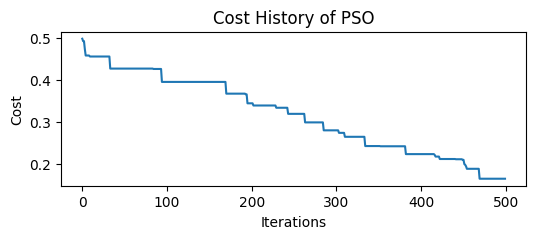

In [ ]:
plt.figure(figsize=(6,2))
plt.plot(optimizer.cost_history)
plt.title('Cost History of PSO')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

# Plot Model

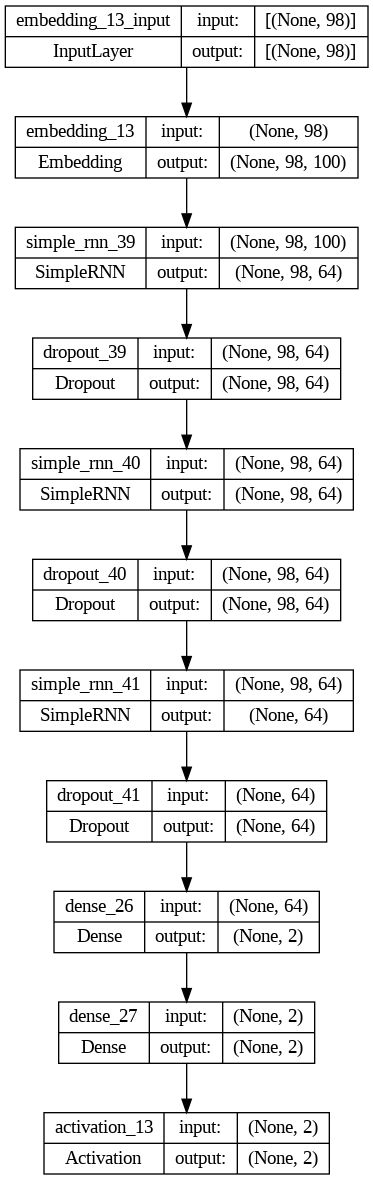

In [ ]:
plot_model(model, show_shapes=True)